In [28]:
import os
import xml.etree.ElementTree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model
from mrcnn import visualize

import numpy as np
from PIL import Image

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

ROOT_DIR = os.path.abspath(".")
MODEL_DIR = os.path.join(ROOT_DIR, "model")
#MODEL_DIR = 'C:/Users/user/Desktop/Mask-RCNN_forTrain3/model/'
print(MODEL_DIR)

c:\Users\user\Desktop\MaskRcnn\model


In [29]:
class KangarooConfig(mrcnn.config.Config):
    NAME = "nod"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    #RPN_ANCHOR_SCALES = (2, 4, 8, 16, 64)
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10

    SAVE_EPOCHES_FREQ_PER_STEP = 2

In [30]:
# class InferenceConfig(KangarooConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1


class InferenceConfig(KangarooConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # POST_NMS_ROIS_INFERENCE  = 200
    DETECTION_MIN_CONFIDENCE = 0.01
    DETECTION_MAX_INSTANCES  = 500
    DETECTION_NMS_THRESHOLD   = 0.99
    RPN_NMS_THRESHOLD = 0.99
    # PRE_NMS_LIMIT  = 12000
    DETECTION_MIN_SUPPRESSION_THRESHOLD = 0.001

inference_config = InferenceConfig()

#Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
                        #   x_cord= 110,
                        #   y_cord=227)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()

# Load trained weights

anchors :  Tensor("Squeeze_16:0", shape=(None, None, 4), dtype=float32)


In [31]:
MODEL_DIR = 'C:/Users/user/Desktop/Mask-RCNN_forTrain3/model/'
model_path = os.path.join(MODEL_DIR, "Kangaro_mask_rcnn_trained_0711_2.h5")
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  C:/Users/user/Desktop/Mask-RCNN_forTrain3/model/Kangaro_mask_rcnn_trained_0711_2.h5


In [32]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

(135, 4)
(65472, 1)


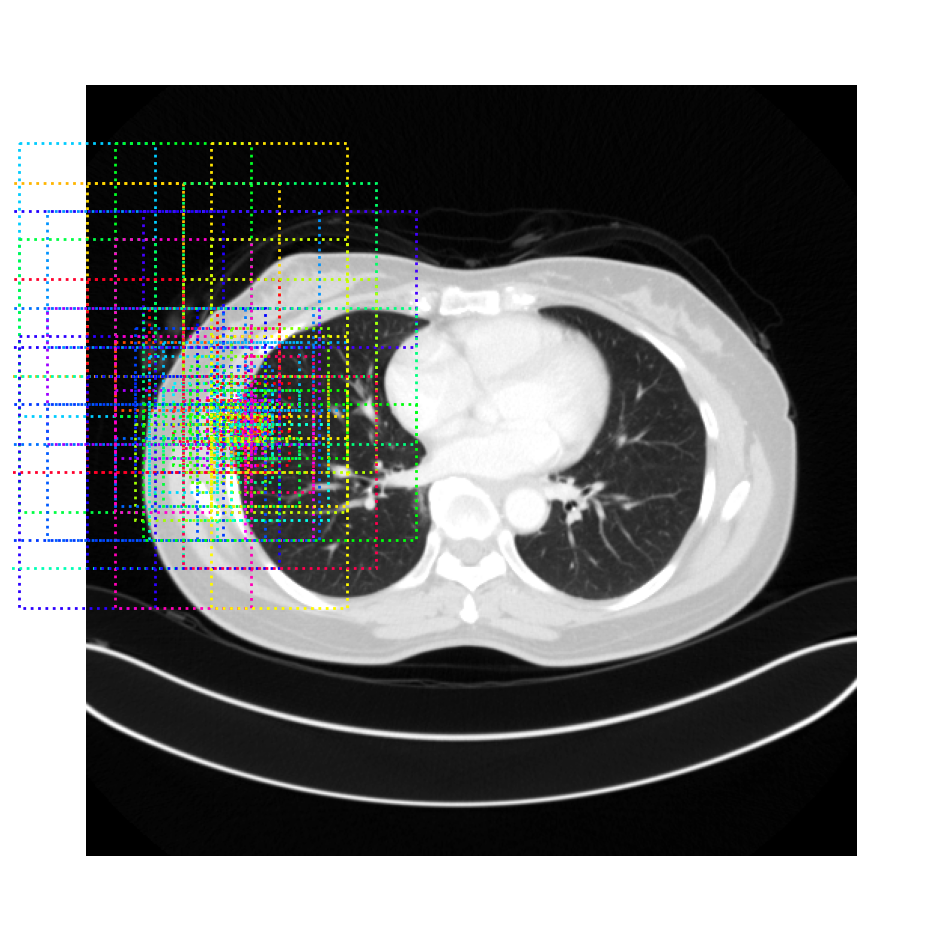

In [33]:
import tensorflow as tf
import cv2
backbone_shapes = mrcnn.model.compute_backbone_shapes(model.config, model.config.IMAGE_SHAPE)
image = cv2.imread("C:/Users/user/Desktop/hospital/Tumor_original/001/001/0060.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def generate_coord_anchors(x,y,scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)
    # print(box_widths.shape)
    # print(box_centers_x.shape)

    # anchor_x = x//feature_stride*(feature_stride)+feature_stride
    # anchor_y = y//feature_stride*(feature_stride)+feature_stride
    # anchor_coord = np.array([anchor_y,anchor_x])

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack([box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    # print('ori_box_centers : ',box_centers.shape)

    anchor_coord = []
    for a in range(-1,2):
        for b in range(-1,2):
            #print(a,b)
            anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
            anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
            anchor_coord.append([anchor_y,anchor_x])
    anchor_coord = np.array(anchor_coord)
    #print('anchor_coord : ',anchor_coord.shape)


    choose_anchor_tmp = []
    for c in range(9):
        choose_anchor_tmp.append(np.all(box_centers == anchor_coord[c], axis=1))

    choose_anchor = choose_anchor_tmp[8]
    for c in range(8):
        choose_anchor = choose_anchor | choose_anchor_tmp[c]

    choose_anchor = np.array(choose_anchor)
    #print('choose_anchor : ',choose_anchor)
    box_centers = box_centers[choose_anchor] #for anchor
    #print('now_box_centers : ',box_centers.shape)

    box_heights = box_heights[:box_centers.shape[0]//3]
    #print('box_heights : ',box_heights.shape)
    box_widths = box_widths[:box_centers.shape[0]//3]
    # print(box_centers.shape)
    # print('box_centers : ')
    # for i in box_heights:
    #     print(i)
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])
    #print('box_sizes',box_sizes.shape)
    # for i in box_sizes:
    #     print(i)
    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    # print('boxes : ')
    # for i in boxes:
    #     print(i)

    
    return boxes,choose_anchor

def generate_coord_pyramid_anchors(x,y,scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    choose_anchors = []
    for i in range(len(scales)):
        anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[0])
        choose_anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[1])
    anchors = np.concatenate(anchors, axis=0)
    choose_anchors = np.concatenate(choose_anchors, axis=0).astype(int)
    choose_anchors = np.expand_dims(choose_anchors,axis=1)
    #anchors = np.expand_dims(anchors,axis=0)
    return anchors,choose_anchors

x = 110
y = 229
anchor,choose_anchors = generate_coord_pyramid_anchors(x,y,
                model.config.RPN_ANCHOR_SCALES,
                model.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                model.config.BACKBONE_STRIDES,
                model.config.RPN_ANCHOR_STRIDE)
print(anchor.shape)
print(choose_anchors.shape)
choose_anchors = np.expand_dims(choose_anchors,axis=0)
mrcnn.visualize.draw_boxes(image,anchor)

# generate_anchors(220,226,model.config.RPN_ANCHOR_SCALES[0], model.config.RPN_ANCHOR_RATIOS, backbone_shapes[0],
#                                         model.config.BACKBONE_STRIDES[0], model.config.RPN_ANCHOR_STRIDE)

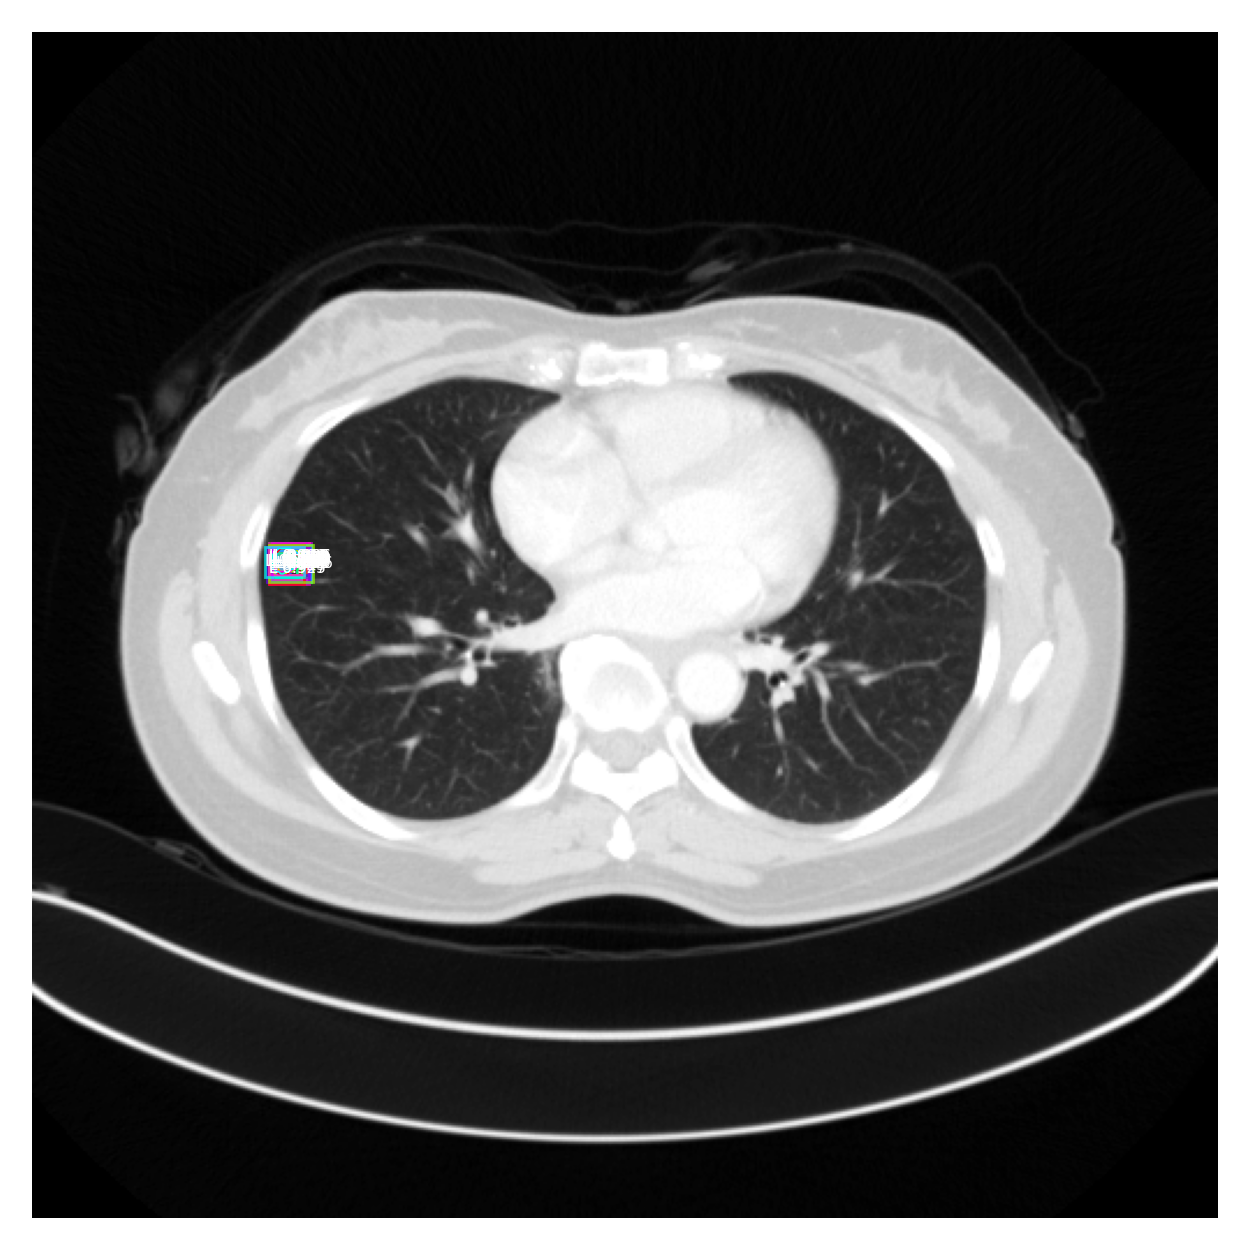

got_bollean 38


In [34]:
import cv2
image = cv2.imread("C:/Users/user/Desktop/hospital/Tumor_original/001/001/0060.png")
#image[image>40] +=50
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Perform a forward pass of the network to obtain the results
r = model.detect_specific_anchor([image],choose_anchors)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names='CLASS_NAMES', 
                                  scores=r['scores'])
# print('-'*50)
# print(r['rois'])
# print('-'*50)
# print(r['masks'])
# print('-'*50)
# print(r['class_ids'])
# print('-'*50)
# print(r['scores'])
# print('-'*50)

got_bollean = 0
concat_mask = np.zeros([512,512])
for i in range(r['masks'].shape[2]):
    if(r['masks'][:,:,i][y,x]==True):
        concat_mask+=r['masks'][:,:,i]
        got_bollean += 1
print('got_bollean',got_bollean)

concat_mask[concat_mask<int(got_bollean//3)] = 0
concat_mask[concat_mask>0]=1


final_mask = np.zeros([512,512])
dice = 0
for i in range(r['masks'].shape[2]):
    if(r['masks'][:,:,i][y,x]==True):
        if(dice<2*np.sum(r['masks'][:,:,i]*concat_mask)/(np.sum(r['masks'][:,:,i])+np.sum(concat_mask))):
            dice = 2*np.sum(r['masks'][:,:,i]*concat_mask)/(np.sum(r['masks'][:,:,i])+np.sum(concat_mask))
            final_mask = r['masks'][:,:,i].astype(np.uint8)    

# final_mask*=255
#cv2.imwrite('C:/Users/user/Desktop/0712img/test.png',final_mask)

In [35]:
import pandas as pd

#! Dice
def dicee(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    
    if union == 0:
        return 1
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    return 2.0 * intersection / union

#! Coverage
def coverage(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    return intersection / np.sum(y_true_f)

def precision(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    return intersection / np.sum(y_pred_f)


In [1]:
! pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\combine_env\python.exe -m pip install --upgrade pip' command.
